Intrusion Detection System

Import Libraries

In [36]:
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


Load Dataset

In [37]:
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.csv"
response = requests.get(url)
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')), header=None)

# Assign column names 
df.columns = [f'feature_{i}' for i in range(df.shape[1]-1)] + ['label']

df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


Preprocess Dataset

In [38]:
X = df.drop('label', axis=1)
y = df['label']

X.columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'extra_1' 
]

print(X.columns.tolist())


['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'extra_1']


Train-Test Split

In [39]:
from sklearn.model_selection import train_test_split


# Make sure X and y are properly preprocessed and aligned before this
X_train, X_test, y_train_labels, y_test_labels = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)



Encode Categorical Columns

In [40]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Label encode the split labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_labels)
y_test_enc = le.transform(y_test_labels)

# One-hot encode
y_train_onehot = to_categorical(y_train_enc)
y_test_onehot = to_categorical(y_test_enc)


Feature Scaling

In [41]:
# Convert categorical columns to numeric
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align test set to train columns (important!)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Now apply scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Neural Network Implementation

In [42]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train_onehot,
    validation_data=(X_test, y_test_onehot),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Predict probabilities and convert to class labels
y_pred_prob_nn = model.predict(X_test)
y_pred_nn = np.argmax(y_pred_prob_nn, axis=1)


Epoch 1/20


/opt/homebrew/anaconda3/envs/intrusionDetection/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2953/2953 - 2s - 807us/step - accuracy: 0.6921 - loss: 0.8566 - val_accuracy: 0.7252 - val_loss: 0.7492
Epoch 2/20
2953/2953 - 2s - 644us/step - accuracy: 0.7324 - loss: 0.7059 - val_accuracy: 0.7364 - val_loss: 0.7026
Epoch 3/20
2953/2953 - 2s - 710us/step - accuracy: 0.7454 - loss: 0.6658 - val_accuracy: 0.7424 - val_loss: 0.6637
Epoch 4/20
2953/2953 - 2s - 645us/step - accuracy: 0.7494 - loss: 0.6420 - val_accuracy: 0.7496 - val_loss: 0.6528
Epoch 5/20
2953/2953 - 2s - 628us/step - accuracy: 0.7547 - loss: 0.6255 - val_accuracy: 0.7531 - val_loss: 0.6502
Epoch 6/20
2953/2953 - 2s - 598us/step - accuracy: 0.7601 - loss: 0.6110 - val_accuracy: 0.7550 - val_loss: 0.6333
Epoch 7/20
2953/2953 - 2s - 624us/step - accuracy: 0.7636 - loss: 0.5964 - val_accuracy: 0.7590 - val_loss: 0.6220
Epoch 8/20
2953/2953 - 2s - 629us/step - accuracy: 0.7681 - loss: 0.5867 - val_accuracy: 0.7626 - val_loss: 0.6126
Epoch 9/20
2953/2953 - 2s - 617us/step - accuracy: 0.7696 - loss: 0.5765 - val_accuracy: 0.

Neural Network Evaluation

985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.40      0.53      0.46        15
           2       0.44      0.31      0.36        13
           3       0.10      0.06      0.08        16
           4       0.28      0.45      0.35        20
           5       0.00      0.00      0.00        20
           6       0.18      0.12      0.15        24
           7       0.28      0.43      0.34        30
           8       0.21      0.19      0.20        26
           9       0.31      0.31      0.31        49
          10       0.26      0.17      0.21        63
          11       0.47      0.62      0.54       160
          12       0.48      0.48      0.48       182
          13       0.29      0.27      0.28       113
          14       0.58      0.56      0.57       169
          15       0.67      0.71      0.69       998

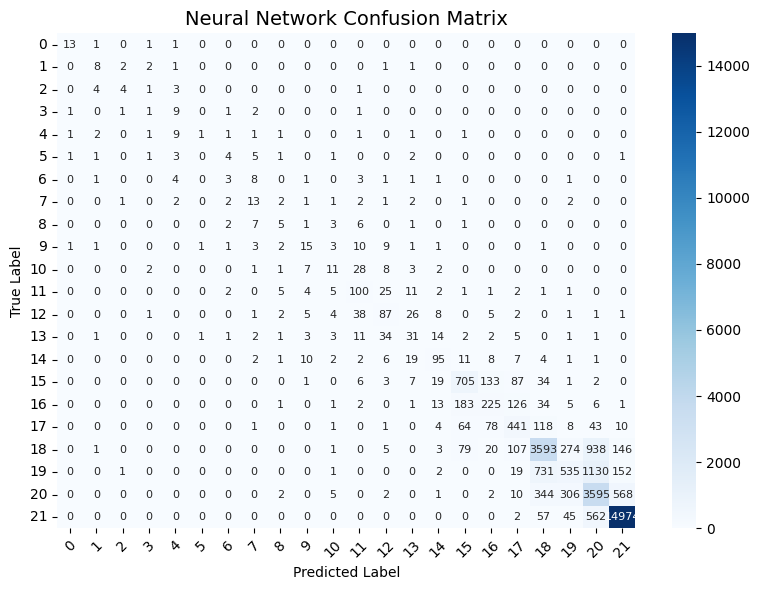

In [43]:
# Predict
y_pred_nn_prob = model.predict(X_test)
y_pred_nn_labels = np.argmax(y_pred_nn_prob, axis=1)

# Ensure test labels are in label format
y_test_labels = np.argmax(y_test_onehot, axis=1)

# Evaluation
print("Neural Network Classification Report:\n")
print(classification_report(y_test_labels, y_pred_nn_labels))

# Accuracy Score
accuracy = accuracy_score(y_test_labels, y_pred_nn_labels)
print("\nAccuracy Score:")
print(round(accuracy, 4))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_nn_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 8})  
plt.title('Neural Network Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Random Forest Implementation

In [44]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_labels)


RandomForestClassifier(random_state=42)

Random Forest Evaluation


Random Forest Accuracy: 0.8967

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.88      0.76        16
           1       0.83      0.33      0.48        15
           2       0.56      0.69      0.62        13
           3       0.53      0.50      0.52        16
           4       0.64      0.45      0.53        20
           5       0.53      0.45      0.49        20
           6       0.63      0.71      0.67        24
           7       0.59      0.43      0.50        30
           8       0.50      0.54      0.52        26
           9       0.70      0.57      0.63        49
          10       0.50      0.49      0.50        63
          11       0.78      0.70      0.74       160
          12       0.75      0.77      0.76       182
          13       0.63      0.55      0.59       113
          14       0.74      0.76      0.75       169
          15       0.86      0.88      0.87       998
          

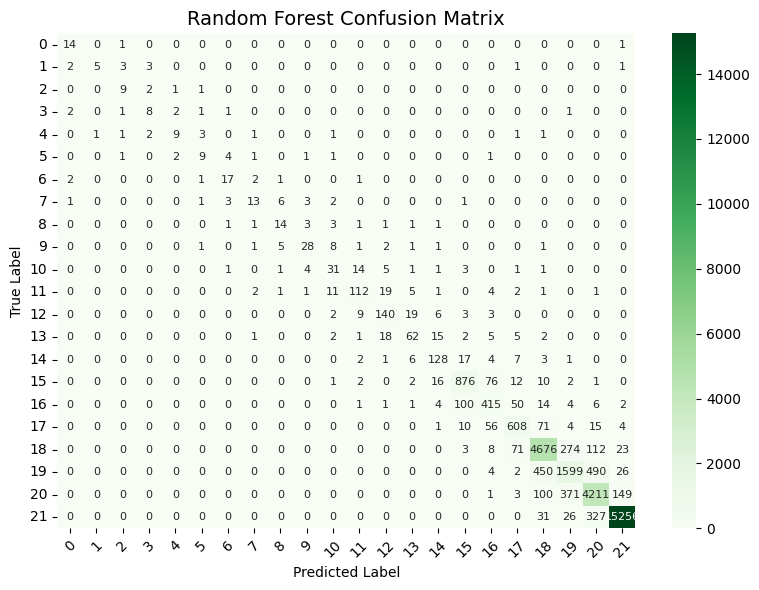

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on Test Set
y_pred_rf = rf_model.predict(X_test)

# Accuracy
accuracy_rf = accuracy_score(y_test_labels, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")

# Classification Report
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test_labels, y_pred_rf))


cm_rf = confusion_matrix(y_test_labels, y_pred_rf)

plt.figure(figsize=(8, 6))  
sns.heatmap(cm_rf, 
            annot=True, 
            fmt='d', 
            cmap='Greens', 
            cbar=True,
            annot_kws={"size": 8})

plt.title('Random Forest Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Random Forest Feature Importance

In [54]:
# Get Feature Names from Dataset
feature_names = X_train.columns                     

# Get Feature Importances from Random Forest
importances = rf_model.feature_importances_
print(len(feature_names) == len(importances))
# Create DataFrame for Visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='Greens_r')
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

XGBoost Hyperparameter Tuning

In [50]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the XGBoost classifier with a fixed evaluation metric
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1)

# Define parameter distributions for randomized search
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model using randomized search
random_search.fit(X_train, y_train_labels)

# Display the best parameters
print("Best Hyperparameters for XGBoost:")
print(random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters for XGBoost:
{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


XGBoost Implementation Using Best Parameters

In [51]:
# Extract the best estimator
best_xgb_model = random_search.best_estimator_

# Fit the best model to the training data
best_xgb_model.fit(X_train, y_train_labels)

# Predict on test data
y_pred_xgb = best_xgb_model.predict(X_test)


XGBoost Evaluation

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate XGBoost predictions
print("XGBoost Classification Report:")
print(classification_report(y_test_labels, y_pred_xgb))

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_xgb))

print("XGBoost Accuracy Score:")
print(f"{accuracy_score(y_test_labels, y_pred_xgb):.4f}")


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.50      0.40      0.44        15
           2       0.82      0.69      0.75        13
           3       0.46      0.38      0.41        16
           4       0.54      0.35      0.42        20
           5       0.67      0.40      0.50        20
           6       0.57      0.50      0.53        24
           7       0.56      0.33      0.42        30
           8       0.53      0.38      0.44        26
           9       0.60      0.37      0.46        49
          10       0.43      0.48      0.45        63
          11       0.74      0.62      0.68       160
          12       0.66      0.69      0.68       182
          13       0.46      0.40      0.43       113
          14       0.71      0.58      0.64       169
          15       0.78      0.81      0.79       998
          16       0.59      0.51      0.55       

Final Comparison

In [55]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Ensure proper label format and matching length
y_test_nn = np.argmax(y_test_onehot, axis=1)
assert len(y_test_nn) == len(y_pred_nn_labels)

# XGBoost
f1_xgb  = f1_score(y_test_labels, y_pred_xgb, average='weighted')
prec_xgb = precision_score(y_test_labels, y_pred_xgb, average='weighted', zero_division=0)
rec_xgb  = recall_score(y_test_labels, y_pred_xgb, average='weighted')
acc_xgb  = accuracy_score(y_test_labels, y_pred_xgb)

# Random Forest
f1_rf  = f1_score(y_test_labels, y_pred_rf, average='weighted')
prec_rf = precision_score(y_test_labels, y_pred_rf, average='weighted', zero_division=0)
rec_rf  = recall_score(y_test_labels, y_pred_rf, average='weighted')
acc_rf  = accuracy_score(y_test_labels, y_pred_rf)

# Neural Network
f1_nn  = f1_score(y_test_nn, y_pred_nn_labels, average='weighted')
prec_nn = precision_score(y_test_nn, y_pred_nn_labels, average='weighted', zero_division=0)
rec_nn  = recall_score(y_test_nn, y_pred_nn_labels, average='weighted')
acc_nn  = accuracy_score(y_test_nn, y_pred_nn_labels)

# Display
print("Model Performance Comparison (Weighted Metrics):\n")
print(f"{'Model':<15} {'F1':>6} {'Precision':>10} {'Recall':>8} {'Accuracy':>10}")
print("-" * 50)
print(f"{'XGBoost':<15} {f1_xgb:.4f}   {prec_xgb:.4f}     {rec_xgb:.4f}   {acc_xgb:.4f}")
print(f"{'Random Forest':<15} {f1_rf:.4f}   {prec_rf:.4f}     {rec_rf:.4f}   {acc_rf:.4f}")
print(f"{'Neural Net':<15} {f1_nn:.4f}   {prec_nn:.4f}     {rec_nn:.4f}   {acc_nn:.4f}")


Model Performance Comparison (Weighted Metrics):

Model               F1  Precision   Recall   Accuracy
--------------------------------------------------
XGBoost         0.8023   0.8068     0.8138   0.8138
Random Forest   0.8958   0.8960     0.8967   0.8967
Neural Net      0.7673   0.7694     0.7768   0.7768
